In [2]:
#imports
import chess.pgn
import numpy as np
import pandas as pd
import missingno as mso
import ast
from evals_calc import evaluate_performance # Import the evaluate_performance function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import pickle



Create a dataframe based on a pgn file

In [60]:
def parse_pgn(pgn_file):
    
    # Open and read the PGN file
    with open(pgn_file, 'r') as f:
        
        games = []
        for game in iter(lambda: chess.pgn.read_game(f), None):
            
            board = game.board() # Create a board for this game to convert the moves from UCI format to normal notation

            # Extract metadata
            event = game.headers.get("Event", "")
            site = game.headers.get("Site", "")
            white_player = game.headers.get("White", "")
            black_player = game.headers.get("Black", "")
            result = game.headers.get("Result", "")
            utc_date = game.headers.get("UTCDate", "")
            utc_time = game.headers.get("UTCTime", "")
            white_elo = game.headers.get("WhiteElo", "")
            black_elo = game.headers.get("BlackElo", "")
            white_rating_diff = game.headers.get("WhiteRatingDiff", "")
            black_rating_diff = game.headers.get("BlackRatingDiff", "")
            eco = game.headers.get("ECO", "")
            opening = game.headers.get("Opening", "")
            time_control = game.headers.get("TimeControl", "")
            termination = game.headers.get("Termination", "")
            
            # Get moves, it gets them in UCI format we need to convert them to standard notation
            moves = []
            
            for move in game.mainline_moves(): 
                moves.append(move.uci())
                board.push(move)
                            
            # Evaluate the performance of both players
            white_perf, black_perf = evaluate_performance(game)

            # Create a dictionary forr game data
            game_data = {
                "Event": event,
                "Site": site,
                "White": white_player,
                "Black": black_player,
                "Result": result,
                "UTCDate": utc_date,
                "UTCTime": utc_time,
                "WhiteElo": white_elo,
                "BlackElo": black_elo,
                "WhiteRatingDiff": white_rating_diff,
                "BlackRatingDiff": black_rating_diff,
                "ECO": eco,
                "Opening": opening,
                "TimeControl": time_control,
                "Termination": termination,
                "Moves": moves,
                "White_Performance": round(white_perf),
                "Black_Performance": round(black_perf)
            }

            # Append game data to the games list
            games.append(game_data)

    # Create a DataFrame from the list of games
    df = pd.DataFrame(games)
    return df

# Parse the PGN file and create the DataFrame
df = parse_pgn("../data/raw/lichess_db_standard_rated_2013-01.pgn")

#Convert the resulting dataframe into a CSV file
df.to_csv("../data/raw/raw_matches.csv")

In [92]:
df = pd.read_csv("../Data/Raw/raw_matches.csv")

# Display the DataFrame
df

,Unnamed: 0,Event,Site,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,Moves,White_Performance,Black_Performance
0,0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,5.0,-8.0,C00,French Defense: Normal Variation,600+8,Normal,"['e2e4', 'e7e6', 'd2d4', 'b7b6', 'a2a3', 'c8b7...",47,53
1,1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,19.0,-22.0,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal,"['d2d4', 'd7d5', 'g1f3', 'g8f6', 'e2e3', 'c8f5...",45,55
2,2,Rated Classical game,https://lichess.org/szom2tog,Kozakmamay007,VanillaShamanilla,1-0,2012.12.31,23:03:15,1643,1747,13.0,-94.0,C50,Four Knights Game: Italian Variation,420+17,Normal,"['e2e4', 'e7e5', 'g1f3', 'b8c6', 'f1c4', 'g8f6...",47,53
3,3,Rated Bullet game,https://lichess.org/rklpc7mk,Naitero_Nagasaki,800,0-1,2012.12.31,23:04:57,1824,1973,-6.0,8.0,B12,Caro-Kann Defense: Goldman Variation,60+1,Normal,"['e2e4', 'c7c6', 'b1c3', 'd7d5', 'd1f3', 'd5e4...",43,57
4,4,Rated Bullet game,https://lichess.org/1xb3os63,nichiren1967,Naitero_Nagasaki,0-1,2012.12.31,23:02:37,1765,1815,-9.0,9.0,C00,French Defense: La Bourdonnais Variation,60+1,Normal,"['e2e4', 'e7e6', 'f2f4', 'd7d5', 'e4e5', 'c7c5...",44,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121327,121327,Rated Classical game,https://lichess.org/4w6vfr19,Yudhisthira,netsah08,0-1,2013.01.31,22:59:08,1854,1937,-9.0,16.0,E80,King's Indian Defense: Saemisch Variation,600+10,Normal,"['d2d4', 'g8f6', 'c2c4', 'g7g6', 'b1c3', 'f8g7...",47,53
121328,121328,Rated Classical game,https://lichess.org/33p7nthu,Daler,kualalumpur,0-1,2013.01.31,22:59:13,1500,1266,-331.0,12.0,B01,Scandinavian Defense,720+0,Time forfeit,"['e2e4', 'd7d5', 'd2d3', 'd5e4', 'd3e4', 'd8d1...",44,56
121329,121329,Rated Classical game,https://lichess.org/pzncnhrt,senip,Richard_XII,0-1,2013.01.31,22:59:27,1431,1523,-70.0,7.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,960+6,Normal,"['e2e4', 'd7d5', 'e4d5', 'd8d5', 'b1c3', 'd5d8...",44,56
121330,121330,Rated Blitz game,https://lichess.org/hhwb2whr,van9,shueardm,1-0,2013.01.31,22:59:41,1693,1479,6.0,-5.0,B00,Barnes Defense,180+1,Normal,"['e2e4', 'f7f6', 'f1c4', 'e7e6', 'd2d4', 'd8e7...",48,52


Delete site column as all data comes from liches website

In [93]:
df = df.drop(columns=["Site"])

df.head()

,Unnamed: 0,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,Moves,White_Performance,Black_Performance
0,0,Rated Classical game,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,5.0,-8.0,C00,French Defense: Normal Variation,600+8,Normal,"['e2e4', 'e7e6', 'd2d4', 'b7b6', 'a2a3', 'c8b7...",47,53
1,1,Rated Classical game,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,19.0,-22.0,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal,"['d2d4', 'd7d5', 'g1f3', 'g8f6', 'e2e3', 'c8f5...",45,55
2,2,Rated Classical game,Kozakmamay007,VanillaShamanilla,1-0,2012.12.31,23:03:15,1643,1747,13.0,-94.0,C50,Four Knights Game: Italian Variation,420+17,Normal,"['e2e4', 'e7e5', 'g1f3', 'b8c6', 'f1c4', 'g8f6...",47,53
3,3,Rated Bullet game,Naitero_Nagasaki,800,0-1,2012.12.31,23:04:57,1824,1973,-6.0,8.0,B12,Caro-Kann Defense: Goldman Variation,60+1,Normal,"['e2e4', 'c7c6', 'b1c3', 'd7d5', 'd1f3', 'd5e4...",43,57
4,4,Rated Bullet game,nichiren1967,Naitero_Nagasaki,0-1,2012.12.31,23:02:37,1765,1815,-9.0,9.0,C00,French Defense: La Bourdonnais Variation,60+1,Normal,"['e2e4', 'e7e6', 'f2f4', 'd7d5', 'e4e5', 'c7c5...",44,56


Delete event column as we have the times of each match. Delete also players name and date and time columns.

In [94]:
df = df.drop(columns=["Event", "White", "Black", "UTCDate", "UTCTime", "Termination", "Unnamed: 0"])

df.head()

,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Moves,White_Performance,Black_Performance
0,1-0,1639,1403,5.0,-8.0,C00,French Defense: Normal Variation,600+8,"['e2e4', 'e7e6', 'd2d4', 'b7b6', 'a2a3', 'c8b7...",47,53
1,1-0,1654,1919,19.0,-22.0,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,"['d2d4', 'd7d5', 'g1f3', 'g8f6', 'e2e3', 'c8f5...",45,55
2,1-0,1643,1747,13.0,-94.0,C50,Four Knights Game: Italian Variation,420+17,"['e2e4', 'e7e5', 'g1f3', 'b8c6', 'f1c4', 'g8f6...",47,53
3,0-1,1824,1973,-6.0,8.0,B12,Caro-Kann Defense: Goldman Variation,60+1,"['e2e4', 'c7c6', 'b1c3', 'd7d5', 'd1f3', 'd5e4...",43,57
4,0-1,1765,1815,-9.0,9.0,C00,French Defense: La Bourdonnais Variation,60+1,"['e2e4', 'e7e6', 'f2f4', 'd7d5', 'e4e5', 'c7c5...",44,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121332 entries, 0 to 121331
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Result             121332 non-null  object 
 1   WhiteElo           121254 non-null  object 
 2   BlackElo           121192 non-null  object 
 3   WhiteRatingDiff    121114 non-null  float64
 4   BlackRatingDiff    121114 non-null  float64
 5   ECO                121332 non-null  object 
 6   Opening            121332 non-null  object 
 7   TimeControl        121332 non-null  object 
 8   Moves              121332 non-null  object 
 9   White_Performance  121332 non-null  int64  
 10  Black_Performance  121332 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 10.2+ MB


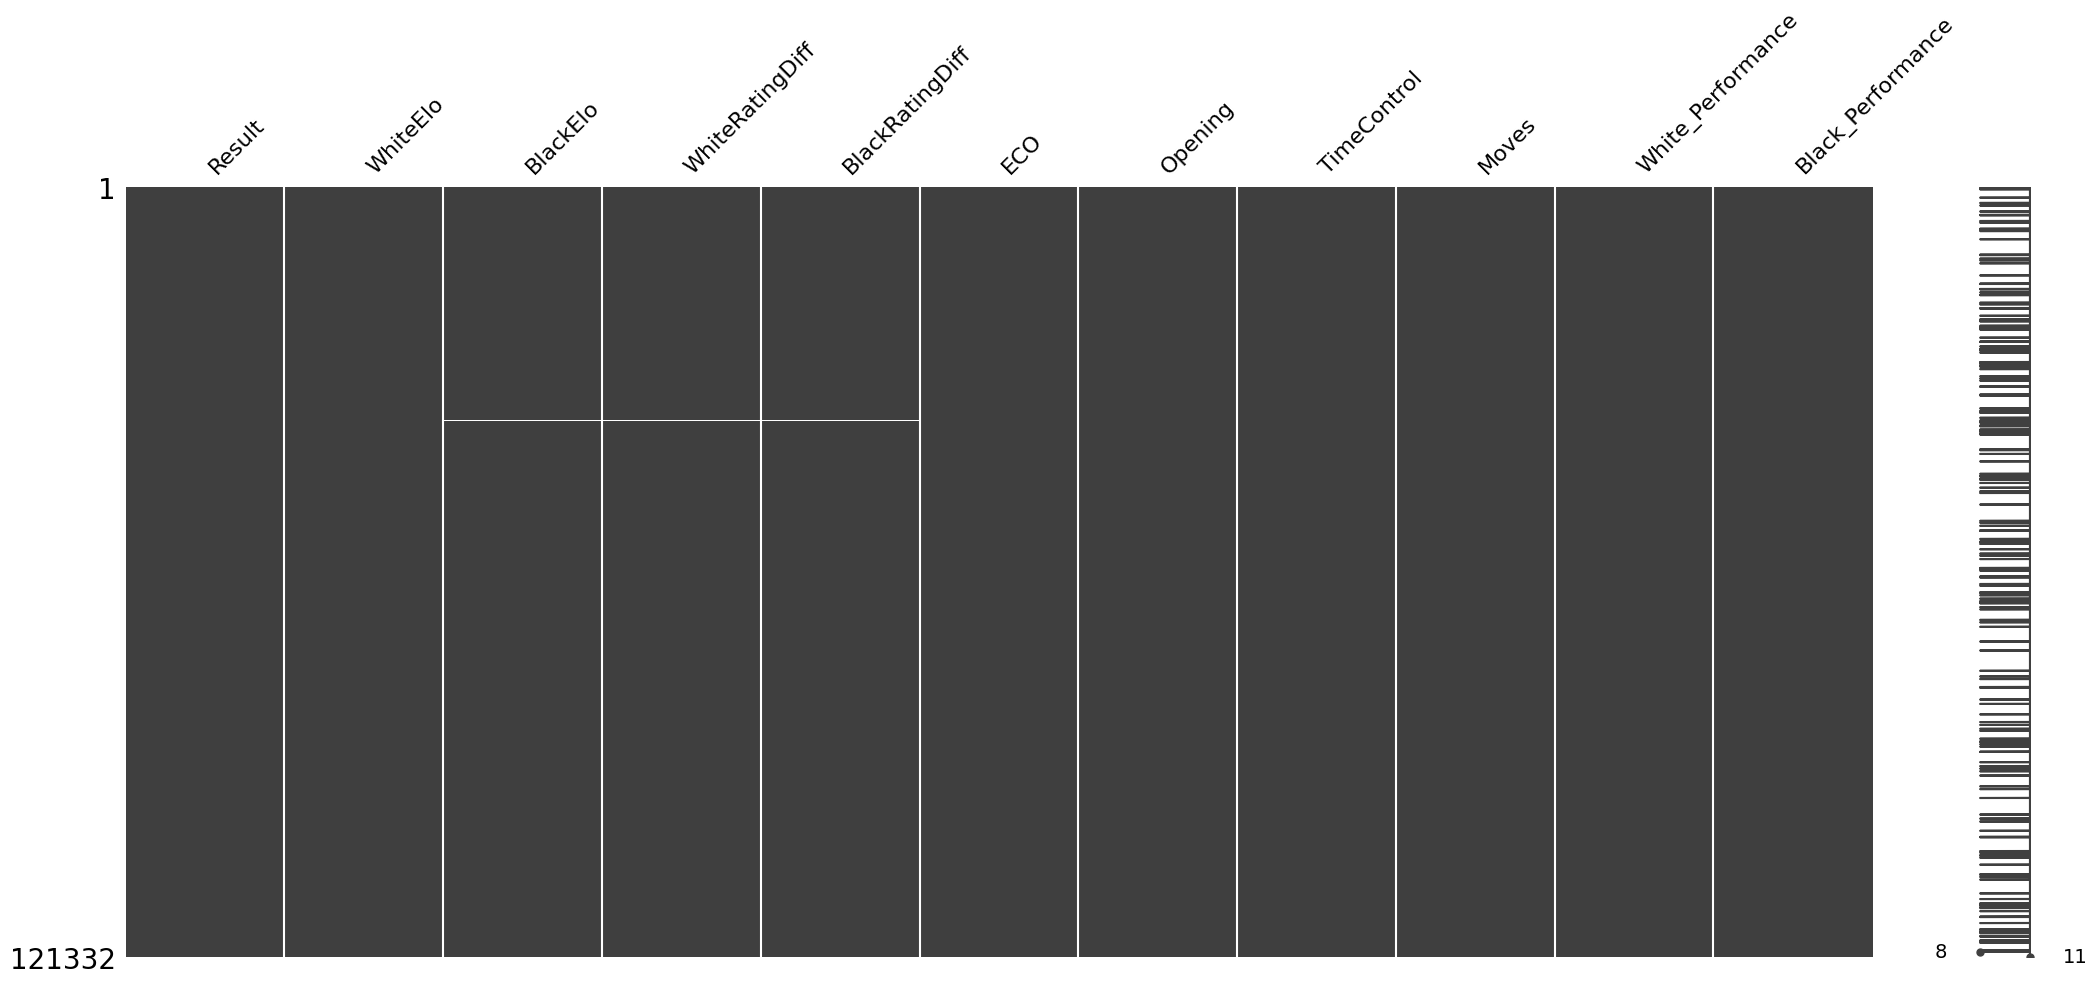

In [95]:
#Replace 'Unknown' and '?' with NaN to know which values are missing
df.replace(['Unknown', '?'], np.nan, inplace=True)

#Use missingno to visualize
mso.matrix(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121114 entries, 0 to 121331
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Result             121114 non-null  object 
 1   WhiteElo           121114 non-null  object 
 2   BlackElo           121114 non-null  object 
 3   WhiteRatingDiff    121114 non-null  float64
 4   BlackRatingDiff    121114 non-null  float64
 5   ECO                121114 non-null  object 
 6   Opening            121114 non-null  object 
 7   TimeControl        121114 non-null  object 
 8   Moves              121114 non-null  object 
 9   White_Performance  121114 non-null  int64  
 10  Black_Performance  121114 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 11.1+ MB


<Axes: >

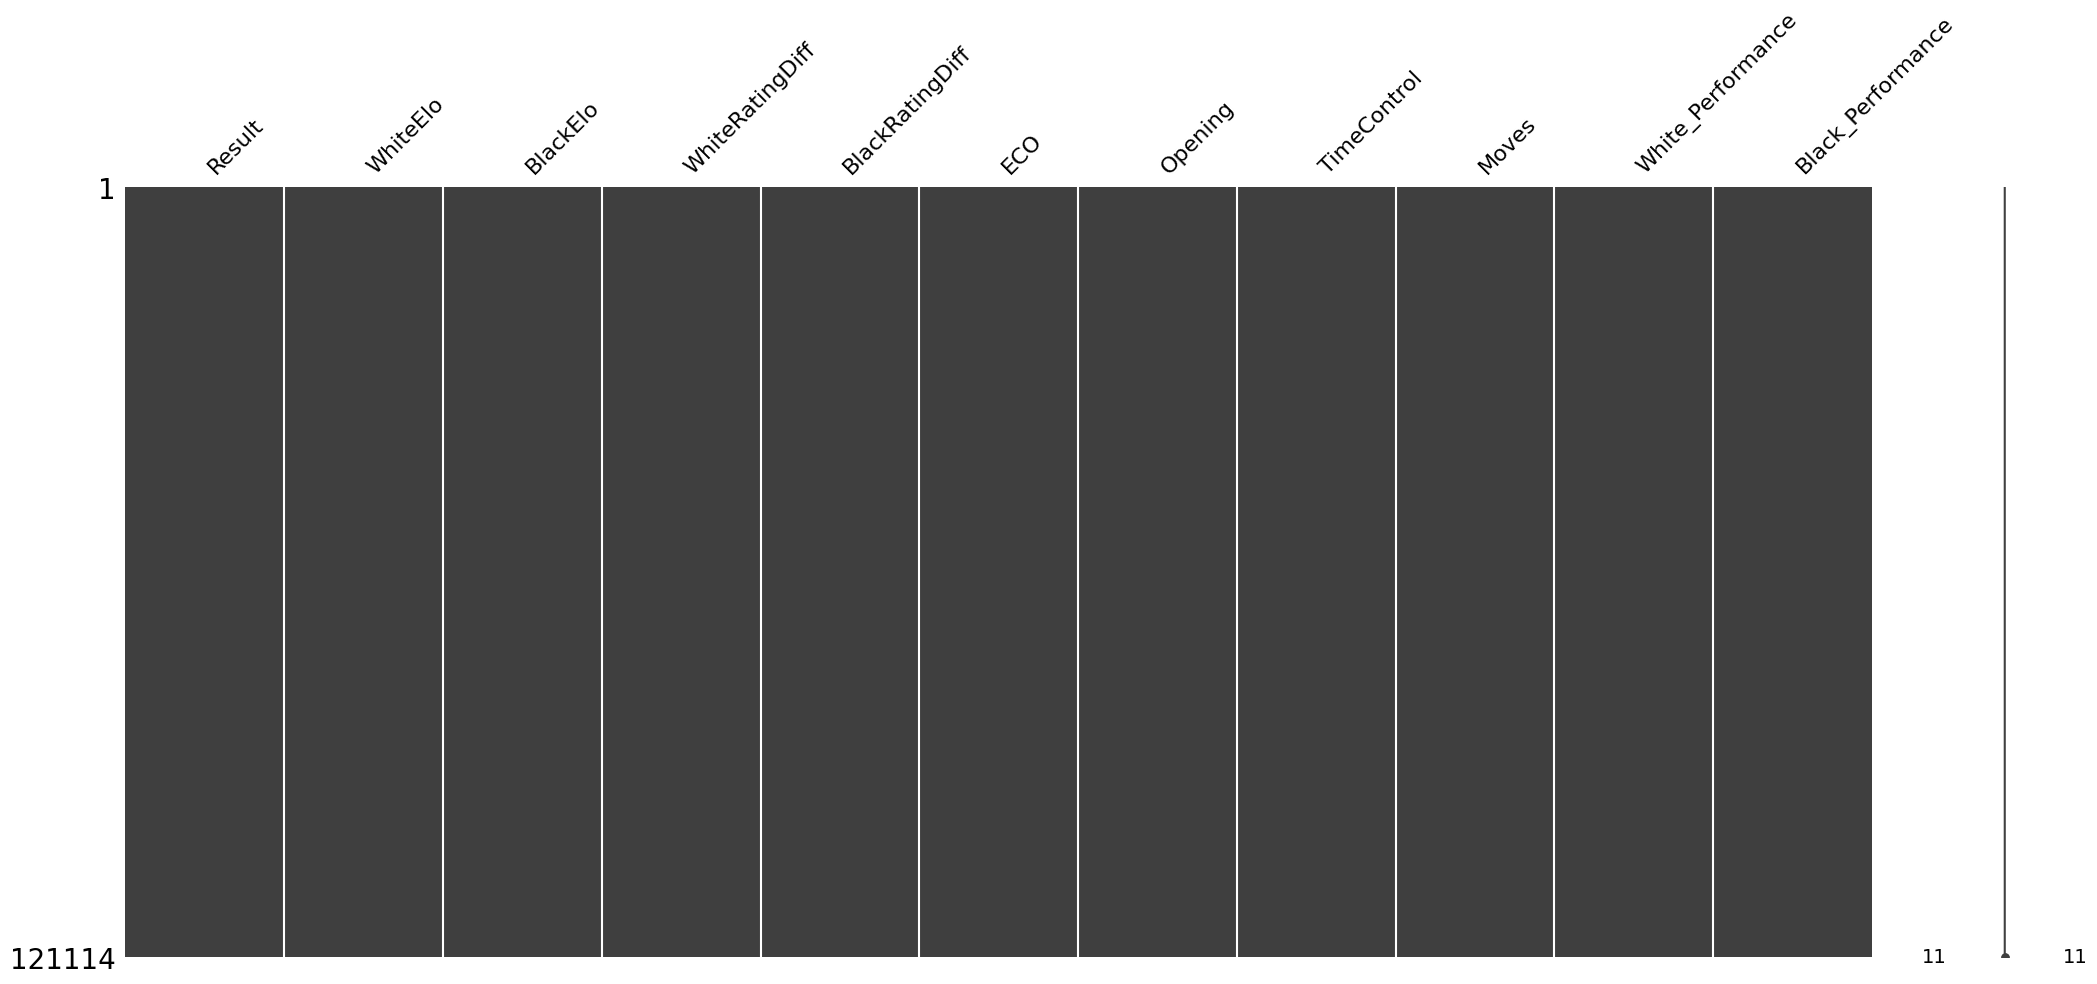

In [96]:
#Drop rows with NaN values
df_clean = df.dropna()

df_clean.info()
mso.matrix(df_clean)

In [97]:
duplicados = df_clean[df_clean.duplicated()]

duplicados

,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Moves,White_Performance,Black_Performance
28289,1-0,1463,1446,25.0,-11.0,C23,Bishop's Opening,420+1,"['e2e4', 'e7e5', 'f1c4', 'b8c6', 'd2d3', 'c6d4...",46,54
40850,1-0,1665,1379,18.0,-52.0,A00,Kadas Opening,60+0,"['h2h4', 'a7a5']",45,55
40861,0-1,1271,1706,-18.0,9.0,A00,Kadas Opening,60+0,"['h2h4', 'a7a5']",45,55
43207,1-0,1755,1500,15.0,-85.0,A00,Kadas Opening,120+0,"['h2h4', 'a7a5', 'g2g4']",46,54
43260,0-1,1385,1814,-28.0,7.0,A00,Kadas Opening,60+0,"['h2h4', 'a7a5']",45,55
43286,0-1,1090,1319,-48.0,12.0,A00,Kadas Opening,300+8,"['h2h4', 'a7a5']",45,55
61035,1-0,1505,980,1.0,-5.0,B00,St. George Defense,120+4,"['e2e4', 'a7a6']",46,54
64440,0-1,1091,1322,-19.0,5.0,A00,Anderssen Opening,600+8,"['a2a3', 'e7e5']",45,55
118915,0-1,1607,1565,-42.0,12.0,A00,Clemenz Opening,60+2,"['h2h3', 'e7e5']",45,55
118918,1-0,1577,1565,10.0,-33.0,B00,St. George Defense,60+2,"['e2e4', 'a7a6', 'g1f3']",46,54


In [98]:
df_clean['WhiteElo'] = pd.to_numeric(df['WhiteElo'])
df_clean['BlackElo'] = pd.to_numeric(df['BlackElo'])

C:\Users\jesus\AppData\Local\Temp\ipykernel_14268\1504258183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['WhiteElo'] = pd.to_numeric(df['WhiteElo'])
C:\Users\jesus\AppData\Local\Temp\ipykernel_14268\1504258183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['BlackElo'] = pd.to_numeric(df['BlackElo'])


In [99]:

df_clean.describe(include= "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Result,121114,3,1-0,62009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WhiteElo,121114.0,NaN,NaN,NaN,1605.973422,202.882684,782.0,1474.0,1602.0,1739.0,2403.0
BlackElo,121114.0,NaN,NaN,NaN,1595.823183,208.041085,789.0,1463.0,1588.0,1732.0,2386.0
WhiteRatingDiff,121114.0,NaN,NaN,NaN,0.239931,35.284212,-517.0,-10.0,2.0,10.0,638.0
BlackRatingDiff,121114.0,NaN,NaN,NaN,-1.508612,38.81493,-504.0,-11.0,-3.0,10.0,614.0
ECO,121114,411,A00,9425,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Opening,121114,1846,Van't Kruijs Opening,3982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TimeControl,121114,394,60+0,14523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Moves,121114,120308,"['e2e4', 'e7e5']",78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White_Performance,121114.0,NaN,NaN,NaN,46.075945,2.762098,20.0,45.0,46.0,47.0,76.0


In [100]:
df_clean["Result"] = df_clean["Result"].replace({'1-0':0, '0-1':1, '1/2-1/2':2 })

C:\Users\jesus\AppData\Local\Temp\ipykernel_14268\416920567.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["Result"] = df_clean["Result"].replace({'1-0':0, '0-1':1, '1/2-1/2':2 })
C:\Users\jesus\AppData\Local\Temp\ipykernel_14268\416920567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Result"] = df_clean["Result"].replace({'1-0':0, '0-1':1, '1/2-1/2':2 })


In [101]:
df_clean.describe(include= "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Result,121114.0,NaN,NaN,NaN,0.520757,0.561305,0.0,0.0,0.0,1.0,2.0
WhiteElo,121114.0,NaN,NaN,NaN,1605.973422,202.882684,782.0,1474.0,1602.0,1739.0,2403.0
BlackElo,121114.0,NaN,NaN,NaN,1595.823183,208.041085,789.0,1463.0,1588.0,1732.0,2386.0
WhiteRatingDiff,121114.0,NaN,NaN,NaN,0.239931,35.284212,-517.0,-10.0,2.0,10.0,638.0
BlackRatingDiff,121114.0,NaN,NaN,NaN,-1.508612,38.81493,-504.0,-11.0,-3.0,10.0,614.0
ECO,121114,411,A00,9425,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Opening,121114,1846,Van't Kruijs Opening,3982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TimeControl,121114,394,60+0,14523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Moves,121114,120308,"['e2e4', 'e7e5']",78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White_Performance,121114.0,NaN,NaN,NaN,46.075945,2.762098,20.0,45.0,46.0,47.0,76.0


In [102]:
df_clean['Moves'] = df_clean['Moves'].apply(ast.literal_eval)

C:\Users\jesus\AppData\Local\Temp\ipykernel_14268\1089148071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Moves'] = df_clean['Moves'].apply(ast.literal_eval)


In [103]:
df_clean = df_clean[df_clean["Moves"].apply(lambda x: len(x) >= 10)]

In [104]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119050 entries, 0 to 121331
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Result             119050 non-null  int64  
 1   WhiteElo           119050 non-null  float64
 2   BlackElo           119050 non-null  float64
 3   WhiteRatingDiff    119050 non-null  float64
 4   BlackRatingDiff    119050 non-null  float64
 5   ECO                119050 non-null  object 
 6   Opening            119050 non-null  object 
 7   TimeControl        119050 non-null  object 
 8   Moves              119050 non-null  object 
 9   White_Performance  119050 non-null  int64  
 10  Black_Performance  119050 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 10.9+ MB


In [105]:
def encode_move(move, is_white):

    # Check for castling (O-O or O-O-O)
    if move == "O-O" or move == "O-O-O":  # Kingside or Queenside castling
        castling = 1
        en_passant = 0
        promotion = 0
        piece_type = 0  
        start_pos = ""
        end_pos = ""
    else:
        castling = 0
        # Check for en passant 
        if "x" in move and move[1] in 'abcdefgh' and move[2] == 'd' and len(move) > 3:
            en_passant = 1
            piece_type = 1 if move[0] in 'abcdefgh' else 0  
            start_pos = move[:2]
            end_pos = move[2:4]
            promotion = 0
        # Check for promotion 
        elif len(move) == 5 and move[4] in 'RNBQ':
            promotion = 1
            piece_type = 1 if move[0] in 'abcdefgh' else 0  
            start_pos = move[:2]
            end_pos = move[2:4]
            en_passant = 0
        else:
            promotion = 0
            en_passant = 0
            piece_type = 1 if move[0] in 'abcdefgh' else 0  # Pawn move or non-pawn move
            start_pos = move[:2]
            end_pos = move[2:]

    # Start and end positions 
    if start_pos:
        col_start = ord(start_pos[0]) - ord('a') + 1
        row_start = int(start_pos[1])
    else:
        col_start, row_start = 0, 0 
    
    if end_pos:
        col_end = ord(end_pos[0]) - ord('a') + 1
        row_end = int(end_pos[1])
    else:
        col_end, row_end = 0, 0  # Same for castling
    
    # Player encoding 
    player = 1 if is_white else 0
    
    # Return the encoded feature vector for this move
    return [piece_type, col_start, row_start, col_end, row_end, castling, en_passant, promotion, player]

# encode all moves in a game 
def encode_game(moves):
    encoded_moves = []
    is_white = True  # White always starts, so first move is white
    for move in moves:
        encoded_move = encode_move(move, is_white)
        encoded_moves.append(encoded_move)
        is_white = not is_white  # Alternate turns between white and black
    return encoded_moves


df_clean['Encoded_Moves'] = df_clean['Moves'].apply(encode_game)

df_clean



,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Moves,White_Performance,Black_Performance,Encoded_Moves
0,0,1639.0,1403.0,5.0,-8.0,C00,French Defense: Normal Variation,600+8,"[e2e4, e7e6, d2d4, b7b6, a2a3, c8b7, b1c3, g8h...",47,53,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 5, 7, 5, 6, ..."
1,0,1654.0,1919.0,19.0,-22.0,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,"[d2d4, d7d5, g1f3, g8f6, e2e3, c8f5, f3h4, f5g...",45,55,"[[1, 4, 2, 4, 4, 0, 0, 0, 1], [1, 4, 7, 4, 5, ..."
2,0,1643.0,1747.0,13.0,-94.0,C50,Four Knights Game: Italian Variation,420+17,"[e2e4, e7e5, g1f3, b8c6, f1c4, g8f6, b1c3, f8c...",47,53,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 5, 7, 5, 5, ..."
3,1,1824.0,1973.0,-6.0,8.0,B12,Caro-Kann Defense: Goldman Variation,60+1,"[e2e4, c7c6, b1c3, d7d5, d1f3, d5e4, c3e4, b8d...",43,57,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 3, 7, 3, 6, ..."
4,1,1765.0,1815.0,-9.0,9.0,C00,French Defense: La Bourdonnais Variation,60+1,"[e2e4, e7e6, f2f4, d7d5, e4e5, c7c5, g1f3, d8b...",44,56,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 5, 7, 5, 6, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
121327,1,1854.0,1937.0,-9.0,16.0,E80,King's Indian Defense: Saemisch Variation,600+10,"[d2d4, g8f6, c2c4, g7g6, b1c3, f8g7, e2e4, d7d...",47,53,"[[1, 4, 2, 4, 4, 0, 0, 0, 1], [1, 7, 8, 6, 6, ..."
121328,1,1500.0,1266.0,-331.0,12.0,B01,Scandinavian Defense,720+0,"[e2e4, d7d5, d2d3, d5e4, d3e4, d8d1, e1d1, b8c...",44,56,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 4, 7, 4, 5, ..."
121329,1,1431.0,1523.0,-70.0,7.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,960+6,"[e2e4, d7d5, e4d5, d8d5, b1c3, d5d8, g1f3, b8c...",44,56,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 4, 7, 4, 5, ..."
121330,0,1693.0,1479.0,6.0,-5.0,B00,Barnes Defense,180+1,"[e2e4, f7f6, f1c4, e7e6, d2d4, d8e7, b1c3, b8c...",48,52,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 6, 7, 6, 6, ..."


In [106]:

df_clean.drop("Moves", axis = 1)


,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,White_Performance,Black_Performance,Encoded_Moves
0,0,1639.0,1403.0,5.0,-8.0,C00,French Defense: Normal Variation,600+8,47,53,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 5, 7, 5, 6, ..."
1,0,1654.0,1919.0,19.0,-22.0,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,45,55,"[[1, 4, 2, 4, 4, 0, 0, 0, 1], [1, 4, 7, 4, 5, ..."
2,0,1643.0,1747.0,13.0,-94.0,C50,Four Knights Game: Italian Variation,420+17,47,53,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 5, 7, 5, 5, ..."
3,1,1824.0,1973.0,-6.0,8.0,B12,Caro-Kann Defense: Goldman Variation,60+1,43,57,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 3, 7, 3, 6, ..."
4,1,1765.0,1815.0,-9.0,9.0,C00,French Defense: La Bourdonnais Variation,60+1,44,56,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 5, 7, 5, 6, ..."
...,...,...,...,...,...,...,...,...,...,...,...
121327,1,1854.0,1937.0,-9.0,16.0,E80,King's Indian Defense: Saemisch Variation,600+10,47,53,"[[1, 4, 2, 4, 4, 0, 0, 0, 1], [1, 7, 8, 6, 6, ..."
121328,1,1500.0,1266.0,-331.0,12.0,B01,Scandinavian Defense,720+0,44,56,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 4, 7, 4, 5, ..."
121329,1,1431.0,1523.0,-70.0,7.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,960+6,44,56,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 4, 7, 4, 5, ..."
121330,0,1693.0,1479.0,6.0,-5.0,B00,Barnes Defense,180+1,48,52,"[[1, 5, 2, 5, 4, 0, 0, 0, 1], [1, 6, 7, 6, 6, ..."


In [107]:
df_clean.to_csv("../data/clean/clean_matches.csv")

In [ ]:
# Load the dataset
df = pd.read_csv('../data/clean/clean_matches.csv')

# Flatten the Encoded_Moves list
def flatten_encoded_moves(encoded_moves):
    return [item for sublist in encoded_moves for item in sublist]

# Flat Encoded_Moves
df['Flattened_Encoded_Moves'] = df['Encoded_Moves'].apply(flatten_encoded_moves)

# Feature Engineering: Extract features from the Encoded_Moves
def extract_move_features(encoded_moves):
    num_moves = len(encoded_moves)
    max_move_length = max(len(move) for move in encoded_moves) if encoded_moves else 0
    return num_moves, max_move_length

# Features
move_features = df['Flattened_Encoded_Moves'].apply(extract_move_features)
move_features_df = pd.DataFrame(move_features.tolist(), columns=['Num_Moves', 'Max_Move_Length'])
df = pd.concat([df, move_features_df], axis=1)
df['Game_Result'] = df['Result'].map({'1-0': 'White Win', '0-1': 'Black Win', '1/2-1/2': 'Draw'})
df['White_Wins'] = (df['Result'] == '1-0').astype(int)
df['Black_Wins'] = (df['Result'] == '0-1').astype(int)
df['Draw'] = (df['Result'] == '1/2-1/2').astype(int)

# Extract features and target
X = df[['Num_Moves', 'Max_Move_Length', 'TimeControl', 'White_Performance', 'Black_Performance', 'BlackElo', 
        'White_Wins', 'Black_Wins', 'Draw', 'WhiteRatingDiff', 'BlackRatingDiff', 'ECO', 'Opening']]
y = df['WhiteElo']

# TimeControl, Opening and ECO with one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('timecontrol', OneHotEncoder(handle_unknown='ignore'), ['TimeControl']),  # OneHot encoding for TimeControl column
        ('scaler', StandardScaler(), ['White_Performance', 'Black_Performance', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff']),  # Standardize performance and Elo ratings
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ['ECO', 'Opening'])  # OneHot encoding for ECO and Opening columns
    ],
    remainder='passthrough'
)

# Build the pipeline with preprocessing and XGBoost Regreessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))  
])

# Split into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict using test
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Save the model
with open('best_chess_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

Mean Squared Error: 6125.63924716363
Mean Absolute Error: 45.92623611443787
R-squared: 0.8495044013254331
Model saved successfully.


In [ ]:
# Load the trained model
def load_model(model_path='best_chess_model.pkl'):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

# Function to parse PGN and extract relevant features
def parse_pgn(pgn_file):
    with open(pgn_file) as f:
        game = chess.pgn.read_game(f)

    # Extract metadata
    white_elo = int(game.headers['WhiteElo'])
    black_elo = int(game.headers['BlackElo'])
    time_control = game.headers['TimeControl']
    white_ratting_diff = float(game.headers['WhiteRatingDiff'])
    black_ratting_diff = float(game.headers['BlackRatingDiff'])
    white_performance, black_performance = evaluate_performance(game)
    

    # Determine the result of the game
    result = game.headers['Result']
    if result == '1-0':  # White wins
        white_wins = 1
        black_wins = 0
        draw = 0
    elif result == '0-1':  # Black wins
        white_wins = 0
        black_wins = 1
        draw = 0
    else:  # Draw
        white_wins = 0
        black_wins = 0
        draw = 1

    # Extract moves
    moves = []
    for move in game.mainline_moves():
        moves.append(move.uci())

    # Flatten the moves
    flattened_encoded_moves = [item for move in moves for item in list(move)]
    
    # Calculate some basic features
    num_moves = len(moves)
    max_move_length = max(len(move) for move in moves)

    # Extract new features: ECO and Opening
    eco = game.headers.get('ECO', 'Unknown')  
    opening = game.headers.get('Opening', 'Unknown')  

    # Feature vector with the updated features
    feature_vector = [num_moves, max_move_length, time_control, white_performance, black_performance,
                      white_elo, black_elo, white_wins, black_wins, draw, white_ratting_diff, black_ratting_diff, eco, opening]

    return feature_vector, flattened_encoded_moves

# Use the saved model to make predictions
def predict_white_elo(model, feature_vector):
    # Define the column names as used during model training
    column_names = ['Num_Moves', 'Max_Move_Length', 'TimeControl', 'White_Performance', 'Black_Performance', 
                    'WhiteElo', 'BlackElo', 'White_Wins', 'Black_Wins', 'Draw', 'WhiteRatingDiff', 
                    'BlackRatingDiff', 'ECO', 'Opening']
    df = pd.DataFrame([feature_vector], columns=column_names)
    
    # Use the model (preprocessor is already fitted inside the pipeline)
    predicted_white_elo = model.predict(df)
    return predicted_white_elo[0]

# Main code execution
if __name__ == "__main__":
    # Load the trained model (which includes the preprocessor)
    model = load_model('best_chess_model.pkl')
    
    # Define the PGN file path (path to your game.pgn file)
    pgn_file = '../data/raw/JoshT1523_vs_SrYisux_2025.03.02.pgn'  # Update with your PGN file path
    
    # Parse the PGN file and extract features
    feature_vector, flattened_encoded_moves = parse_pgn(pgn_file)

    # Make a prediction for White Elo
    predicted_white_elo = predict_white_elo(model, feature_vector)

    print(f"Predicted White Elo: {int(predicted_white_elo)}")


Predicted White Elo: 1238
